We continue the project by building a machine learning model that can predict customers who leave a generous tip (20% or more).

In [314]:
# Imports
import numpy as np
import pandas as pd
pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

#import scipy.stats as stats #ttest
#import statsmodels.api as sm  #stats.anova_lm, qqplot, Logit, OLS
#import statsmodels.formula.api as smf  #formula interface, ols, logit
#from statsmodels.stats.multicomp import pairwise_tukeyhsd #Tukey's HSD function

from sklearn.preprocessing import StandardScaler  #standardise data
from sklearn.model_selection import train_test_split  #train_test_split

#from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV

import sklearn.metrics as metrics  #confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, accuracy_score, roc_auc_score
#from sklearn.metrics import RocCurveDisplay  #from_predictions
#from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

import pickle

In [315]:
#load the dataframe from the previous notebook
df03=pd.read_pickle('taxi_data_processed.pkl')

In [316]:
df03.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,pickup_dropoff,mean_distance,mean_duration,day,month,rush_hour,predicted_fare
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,14.066667,"(100, 231)",3.521667,22.847222,Saturday,March,False,16.754981
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,26.500000,"(186, 43)",3.108889,24.470370,Tuesday,April,False,16.417774
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.200000,"(262, 236)",0.881429,7.250000,Friday,December,True,6.407899
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,"(188, 97)",3.700000,30.250000,Sunday,May,False,19.455534
4,30841670,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,16.716667,"(4, 112)",4.435000,14.616667,Saturday,April,False,16.038586


### Feature engineering

We make a column with the percentage tip and another with a bool for whether the tip was greater than 20%

In [317]:
df03['tip_percent']=df03['tip_amount']/(df03['total_amount']-df03['tip_amount'])
df03['tip_percent']=df03['tip_percent'].round(decimals=3)

In [318]:
df03['generous']=df03['tip_percent']>=0.2

In [319]:
df03.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,pickup_dropoff,mean_distance,mean_duration,day,month,rush_hour,predicted_fare,tip_percent,generous
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,14.066667,"(100, 231)",3.521667,22.847222,Saturday,March,False,16.754981,0.200,True
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,26.500000,"(186, 43)",3.108889,24.470370,Tuesday,April,False,16.417774,0.238,True
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.200000,"(262, 236)",0.881429,7.250000,Friday,December,True,6.407899,0.199,False
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,"(188, 97)",3.700000,30.250000,Sunday,May,False,19.455534,0.300,True
4,30841670,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,16.716667,"(4, 112)",4.435000,14.616667,Saturday,April,False,16.038586,0.000,False


### Exploratory data analysis

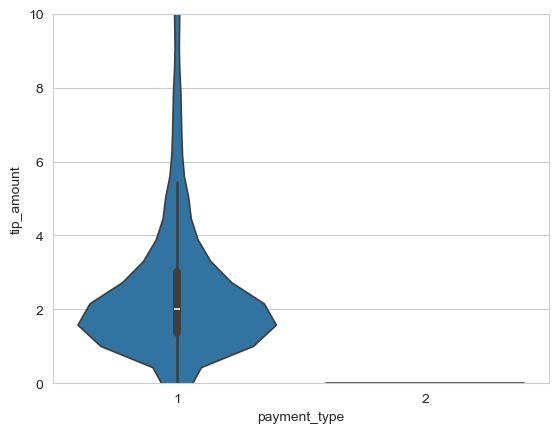

In [320]:
ax=sns.violinplot(data=df03,y='tip_amount',x='payment_type');
ax.set_ylim([0,10]);

In [321]:
df03.groupby('payment_type')['tip_amount'].agg(['mean','min','max'])

,mean,min,max
payment_type,,,
1,2.695354,0.0,55.5
2,0.000000,0.0,0.0


No tip is recorded for cash transaction (payment_type==2). So we take only card transactions.

In [322]:
df=df03[df03['payment_type']==1]

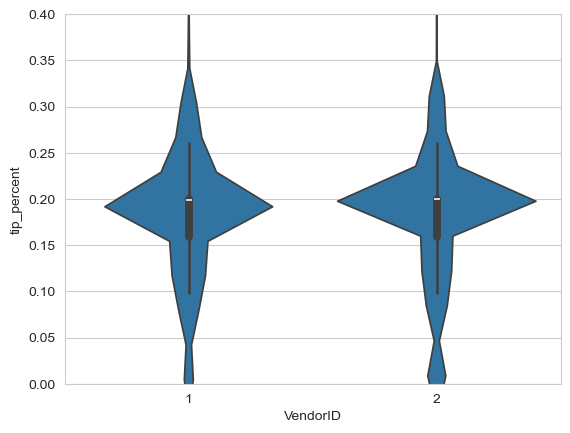

In [323]:
ax=sns.violinplot(data=df,y='tip_percent',x='VendorID');
ax.set_ylim([0,0.4]);

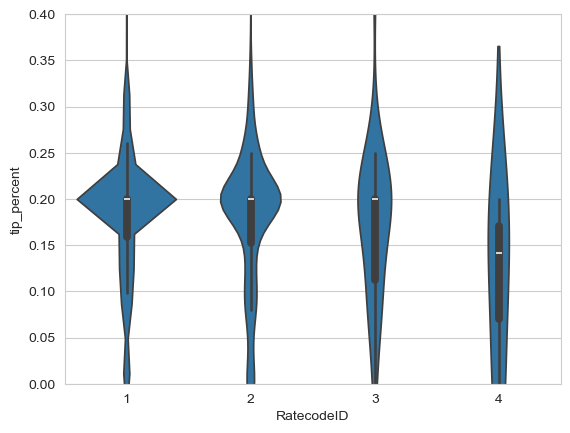

In [324]:
ax=sns.violinplot(data=df,y='tip_percent',x='RatecodeID');
ax.set_ylim([0,0.4]);

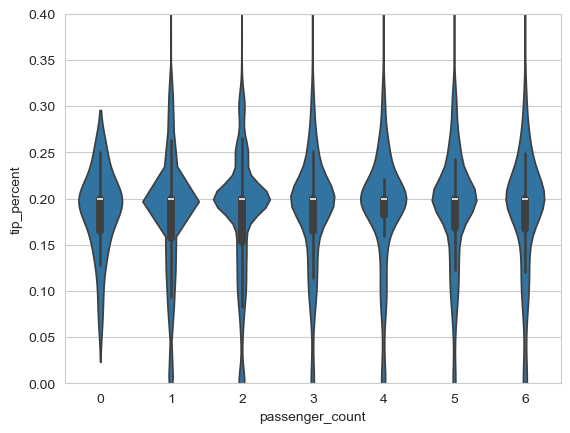

In [325]:
ax=sns.violinplot(data=df,y='tip_percent',x='passenger_count');
ax.set_ylim([0,0.4]);

tip_percent does not appear to depend on VendorID and passenger_count. However, Ratecode 3 (Newark) and especially 4 (Nassau or Westchester) have lower median tip percentages.

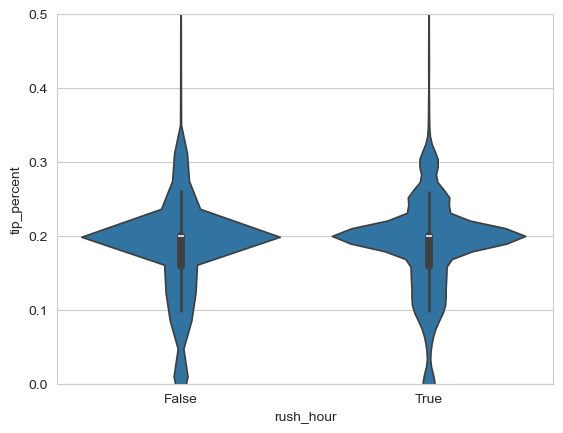

In [326]:
ax=sns.violinplot(data=df,y='tip_percent',x='rush_hour');
ax.set_ylim([0,0.5]);

Rush hour also appears to have little connection.
What about nighttime or the evening rush?

In [327]:
df['time']=3 #nighttime
df.loc[(datetime.time(6,0,0)<=df['tpep_pickup_datetime'].dt.time)  & (df['tpep_pickup_datetime'].dt.time<datetime.time(10,0,0)),'time']=0 #am rush 

df.loc[(datetime.time(10,0,0)<=df['tpep_pickup_datetime'].dt.time)  & (df['tpep_pickup_datetime'].dt.time<datetime.time(16,0,0) ) ,'time']=1 #daytime

df.loc[(datetime.time(16,0,0)<=df['tpep_pickup_datetime'].dt.time)  & (df['tpep_pickup_datetime'].dt.time<datetime.time(20,0,0) ) ,'time']=2 #pm rush


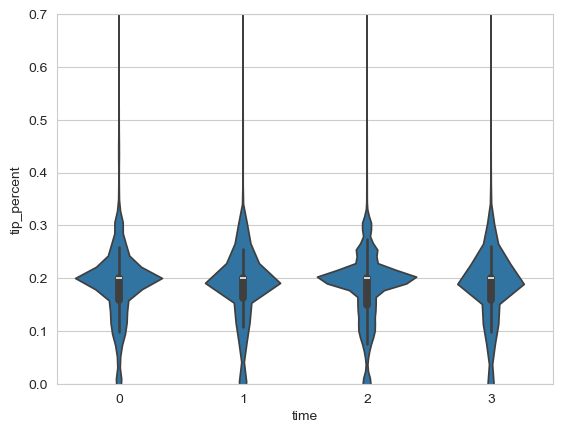

In [328]:
ax=sns.violinplot(data=df,y='tip_percent',x='time');
ax.set_ylim([0,0.7]);

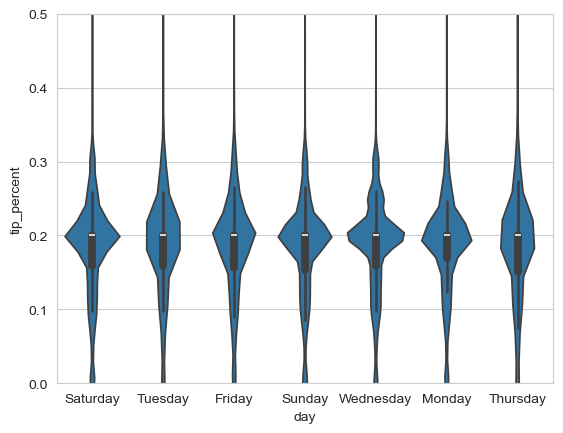

In [330]:
ax=sns.violinplot(data=df,y='tip_percent',x='day');
ax.set_ylim([0,0.5]);

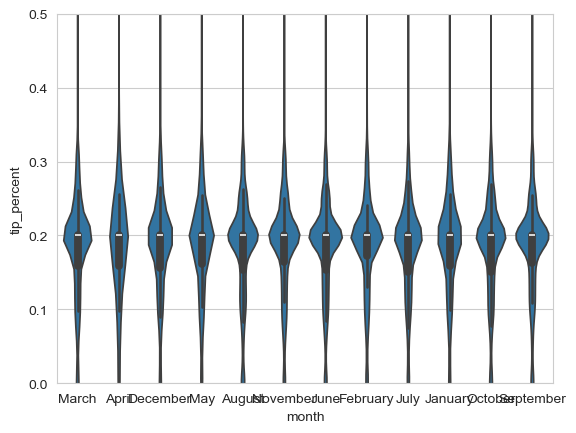

In [331]:
ax=sns.violinplot(data=df,y='tip_percent',x='month');
ax.set_ylim([0,0.5]);

Little evidence for day, month or time dependence

### Feature selection

We drop columns that would not be known in advance or are not relevant. It turns out that removing passenger_count and VendorID decreases the accuracy of the model substantially despite there not be an obvious correlation in either variable with the output label. The model evidently finds more complex, indirect relationships. On the other hand as high cardinality categorical variables PULocationID and DOLocationID complicate the model without bringing any benefit.

In [337]:
df1=df.drop(columns=['Unnamed: 0','tpep_pickup_datetime','tpep_dropoff_datetime','duration','fare_amount','payment_type', 'trip_distance', 'tip_amount', 'tip_percent', 'total_amount', 'tolls_amount','improvement_surcharge','mta_tax','extra','store_and_fwd_flag','pickup_dropoff','rush_hour','PULocationID','DOLocationID'])
df1

,VendorID,passenger_count,RatecodeID,mean_distance,mean_duration,day,month,predicted_fare,generous,time
0,2,6,1,3.521667,22.847222,Saturday,March,16.754981,True,0
1,1,1,1,3.108889,24.470370,Tuesday,April,16.417774,True,1
2,1,1,1,0.881429,7.250000,Friday,December,6.407899,False,0
3,2,1,1,3.700000,30.250000,Sunday,May,19.455534,True,1
5,2,6,1,2.052258,11.855376,Saturday,March,10.267714,True,3
...,...,...,...,...,...,...,...,...,...,...
22692,1,1,1,5.700000,18.016667,Sunday,July,NaN,True,3
22693,2,1,1,1.062778,8.095370,Thursday,August,NaN,True,3
22695,2,1,2,18.757500,59.560417,Sunday,August,52.000000,True,2
22697,2,1,1,2.077500,16.650000,Saturday,July,NaN,False,1


### Variable encoding

In [338]:
#cols_to_str=['RatecodeID','PULocationID','DOLocationID','day','month','time']
cols_to_str=['day','month','time']
for i in cols_to_str:
    df1[i]=df1[i].astype(str)
    
df2=pd.get_dummies(df1,drop_first=True)
df2.head()

,VendorID,passenger_count,RatecodeID,mean_distance,mean_duration,predicted_fare,generous,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September,time_1,time_2,time_3
0,2,6,1,3.521667,22.847222,16.754981,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,1,1,1,3.108889,24.470370,16.417774,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2,1,1,1,0.881429,7.250000,6.407899,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
3,2,1,1,3.700000,30.250000,19.455534,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False
5,2,6,1,2.052258,11.855376,10.267714,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True


### Metric choice

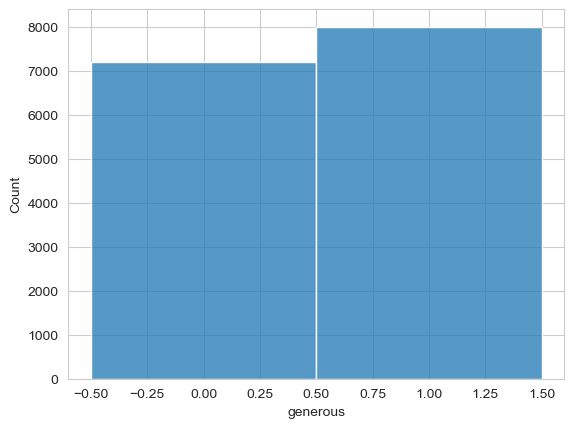

In [339]:
sns.histplot(data=df2,x='generous',discrete=True);

The class labels are relatively balanced. We choose the F1 metric as it is measures both false positives (disappointed driver) and false negatives (potentially disappointed customer)

### Prepare the data

In [340]:
y=df2['generous']
X=df2.drop(columns='generous')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state =0)

### Random Forest model

In [382]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# after some exploration, we find the following hyperparameters work well
cv_params = {'max_depth': [None], 
             'min_samples_leaf': [20,22,24],
             'min_samples_split': [2,4],
             'max_features': [1.0],
             'n_estimators': [100],
             'max_samples' : [0.7]
             }  

# scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiate the GridSearchCV object

rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='f1',n_jobs=6)

In [383]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: total: 3.14 s
Wall time: 14.3 s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0), n_jobs=6,
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [0.7], 'min_samples_leaf': [20, 22, 24],
                         'min_samples_split': [2, 4], 'n_estimators': [100]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [384]:
rf_cv.best_score_

0.7457933574352916

In [385]:
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 22,
 'min_samples_split': 2,
 'n_estimators': 100}

helper function:

In [386]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
    model_name (string): what you want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        },
                       )

    return table

In [422]:
results=make_results('Random Forest',rf_cv,'f1')
results

,model,precision,recall,F1,accuracy
0,Random Forest,0.69117,0.809845,0.745793,0.710373


In [423]:
rf_preds=rf_cv.best_estimator_.predict(X_test)

helper function:

In [389]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
    model_name (string): Your choice: how the model will be named in the output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

    Out:
    table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = metrics.accuracy_score(y_test_data, preds)
    precision = metrics.precision_score(y_test_data, preds)
    recall = metrics.recall_score(y_test_data, preds)
    f1 = metrics.f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

In [424]:
rf_test_scores=get_test_scores('Random Forest test',rf_preds,y_test)
results = pd.concat([results, rf_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest,0.691170,0.809845,0.745793,0.710373
0,Random Forest test,0.699893,0.806173,0.749283,0.712500


Let's plot the confusion matrix

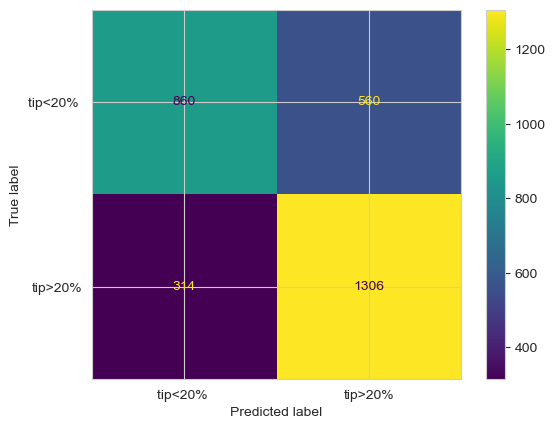

In [391]:
cm=metrics.confusion_matrix(y_test,rf_preds)
p=metrics.ConfusionMatrixDisplay(cm,display_labels=['tip<20% ','tip>20%'])#display_labels=xgb_cv.classes_
p.plot(values_format='d')

And the importance of the features

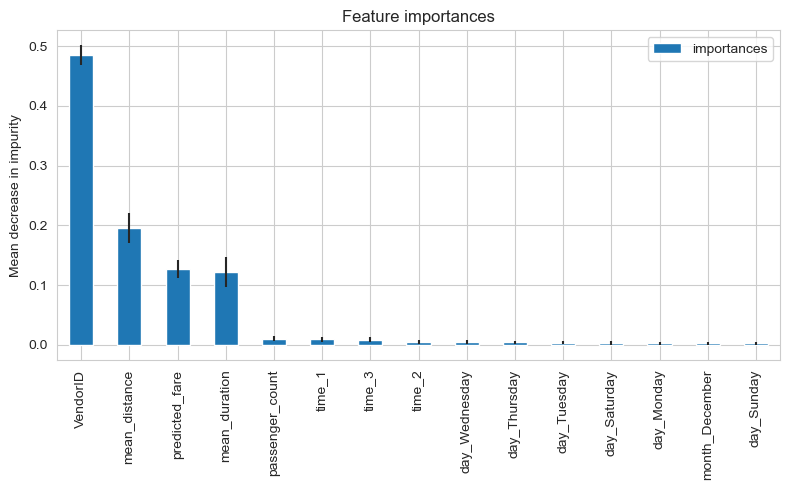

In [441]:
importances = rf_cv.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_cv.best_estimator_.estimators_], axis=0)
rf_importances = pd.DataFrame(data={'importances':importances,'std':std}, index=X_test.columns)

rf_importances = rf_importances.sort_values(ascending=False,by='importances')[:15]

fig, ax = plt.subplots(figsize=(8,5))
rf_importances.plot.bar(yerr='std',ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout();

Despite VendorID have no direct correlation with generosity, it is the most important feature using this metric (impurity).

### XGBoost

In [410]:
#Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0) 

# hyperparameters
cv_params = {'max_depth': [3,2,1],
              'min_child_weight': [1, 2, 3],
              'learning_rate': [0.1,0.3],
              'n_estimators': [500],
              #'subsample': [0.7],
              #'colsample_bytree': [0.7]
              }

# scoring metrics
scoring = ['accuracy', 'precision', 'recall', 'f1']

#Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='f1',n_jobs=6)

In [411]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: total: 6.36 s
Wall time: 7.99 s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             n_jobs=6,
             param_grid={'learning_rate': [0.1, 0.3], 'max_depth': [3, 2, 1],
                         'min_child_weight': [1, 2, 3], 'n_estimators': [500]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [412]:
xgb_cv.best_score_

0.7410894039694222

In [413]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 500}

In [425]:
xgb_scores=make_results('XGBoost',xgb_cv,'f1')
results = pd.concat([results, xgb_scores], axis=0)
results

Run on test data:

In [417]:
xgb_preds=xgb_cv.best_estimator_.predict(X_test)

In [426]:
xgb_test_scores=get_test_scores('XGBoost test',xgb_preds,y_test)
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest,0.691170,0.809845,0.745793,0.710373
0,Random Forest test,0.699893,0.806173,0.749283,0.712500
0,XGBoost,0.691842,0.797931,0.741089,0.707494
0,XGBoost test,0.704767,0.803086,0.750721,0.715789


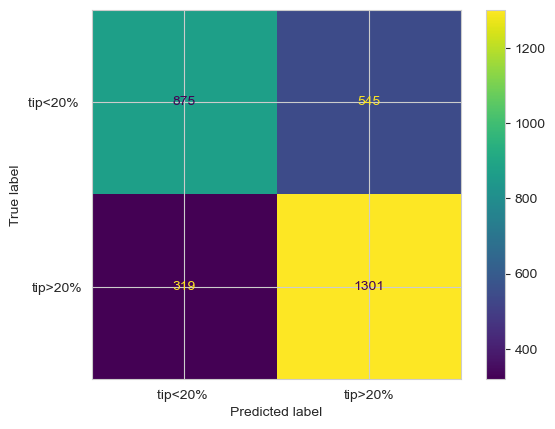

In [427]:
cm=metrics.confusion_matrix(y_test,xgb_preds)
p=metrics.ConfusionMatrixDisplay(cm,display_labels=['tip<20% ','tip>20%'])#display_labels=xgb_cv.classes_
p.plot(values_format='d')

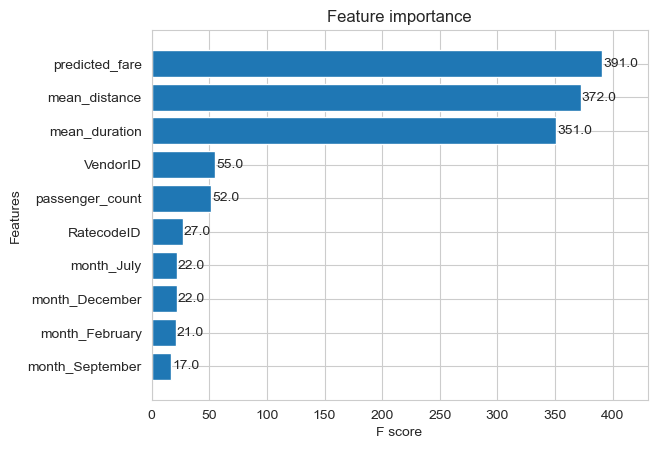

In [428]:
#XGBoost has its own function to plot importances
plot_importance(xgb_cv.best_estimator_,height=0.8,max_num_features=10);

### Conclusion

While, the two models score very similarly, the XGBoost model scores slightly better on the test data with recall of 80% and an accuracy of 72%.